In [ ]:
pip install contextily

In [1]:
import geopandas as gpd
from shapely.geometry import box, Point
import contextily as ctx
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.image import imread
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

def load_animation_data(y, x, width, ratio):

    # Create bbox
    point_gdf = gpd.GeoDataFrame(geometry=[Point(x, y)], 
                                 crs='EPSG:4326').to_crs('EPSG:3577')
    xmin = point_gdf.geometry.x.item() - width
    xmax = point_gdf.geometry.x.item() + width
    ymin = point_gdf.geometry.y.item() - (width * ratio)
    ymax = point_gdf.geometry.y.item() + (width * ratio)
    bounds = [xmin, ymin, xmax, ymax]
    bbox = gpd.GeoDataFrame(geometry=[box(*bounds)], 
                            crs='EPSG:3577')

    # # Set up WFS requests for annual coastlines & rates of change statistics
    # deacl_coastlines_wfs = 'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
    #                        'service=WFS&version=1.1.0&request=GetFeature&' \
    #                        'typeName=dea:coastlines&maxFeatures=1000&' \
    #                       f'bbox={ymin},{xmin},{ymax},{xmax},urn:ogc:def:crs:EPSG:4326'

    # # Load data from WFS and set CRS
    # deacl_gdf = gpd.read_file(deacl_coastlines_wfs)
    # deacl_gdf.crs = 'EPSG:3577'

    # Load data
    deacl_gdf = gpd.read_file('/g/data/r78/DEACoastlines/DEACoastlines_annualcoastlines_v1.1.1.shp', bbox=bbox)

    # Clip to extent of satellite data 
    deacl_gdf = gpd.overlay(deacl_gdf, bbox)
    deacl_gdf = deacl_gdf.dissolve('year')

    # Apply colours
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(deacl_gdf.index))
    cmap = matplotlib.cm.get_cmap('inferno')
    rgba = cmap(norm(deacl_gdf.reset_index().index))
    deacl_gdf['color'] = list(rgba)
    deacl_gdf.at['2020', 'color'] = 'white'
    deacl_gdf.plot(color=deacl_gdf['color'], figsize=(10, 10))
    
    return deacl_gdf, bounds


def plot_alltime(site, deacl_gdf, bounds, legend_width, offset):
    
    # Creat plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    deacl_gdf.plot(ax=ax, color=deacl_gdf.color, linewidth=2)
    xmin, ymin, xmax, ymax = bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.patch.set_facecolor('black')

    # Add basemap
    ctx.add_basemap(ax, 
                    source='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
                    crs='EPSG:3577',
                    alpha=0.75)
    ax.annotate('Annual\nshoreline\npositions', xy=(710, 42 + offset), xycoords='axes points', size=20, ha='left', color='white')
    ax.annotate('1988 - 2020', xy=(337, 42 + offset), xycoords='axes points', size=60, color='white')
    
    # Add image overlay
    arr_lena = imread('/g/data/r78/DEACoastlines/visualisation/images/DEACoastlines_logo.png')
    imagebox = OffsetImage(arr_lena, zoom=0.14)
    ab = AnnotationBbox(imagebox, xy=(90, 370), xycoords='axes points', frameon=False)
    ax.add_artist(ab)

    # Add image overlay
    arr_lena = imread('/g/data/r78/DEACoastlines/visualisation/images/DEACoastlines_key.png')
    imagebox = OffsetImage(arr_lena, zoom=0.41)
    ab = AnnotationBbox(imagebox, xy=(522, 110 + offset), xycoords='axes points', frameon=False)
    ax.add_artist(ab)

    # Add scalebar
    scalebar = AnchoredSizeBar(ax.transData,
                           legend_width, f'{legend_width} m', 'lower left', 
                           pad=2.5, 
                           color='white',
                           frameon=False,
                           sep=10,
                           fontproperties=fm.FontProperties(size=18)) 
    ax.add_artist(scalebar);

    # Export to file
    ax.axis('off')
    plt.savefig(f'Frames/{site}_2021.png',bbox_inches='tight',transparent=True, pad_inches=0, dpi=150)

    
def plot_years(site, deacl_gdf, bounds, legend_width, offset):

    fig, ax = plt.subplots(1, 1, figsize=(15, 15))

    for i, year in enumerate(deacl_gdf.index):

        print(year)

        # Plot data
        year_gdf = deacl_gdf.loc[[year]]
        year_gdf.plot(ax=ax, color='black', linewidth=3)
        xmin, ymin, xmax, ymax = bounds
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.patch.set_facecolor('black')

        # Add basemap
        ctx.add_basemap(ax, 
                        source='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
                        crs='EPSG:3577',
                        alpha=0.75)
        ax.annotate('Median\nshoreline\nposition', xy=(710, 42 + offset), xycoords='axes points', size=20, ha='left', color='white')
        ax.annotate(year, xy=(500, 40 + offset), xycoords='axes points', size=80, color='white')
        ax.axis('off')
        
        # Add image overlay
        arr_lena = imread('/g/data/r78/DEACoastlines/visualisation/images/DEACoastlines_logo.png')
        imagebox = OffsetImage(arr_lena, zoom=0.14)
        ab = AnnotationBbox(imagebox, xy=(90, 370), xycoords='axes points', frameon=False)
        ax.add_artist(ab)

        # Add scalebar
        scalebar = AnchoredSizeBar(ax.transData,
                               legend_width, f'{legend_width} m', 'lower left', 
                               pad=2.5, 
                               color='white',
                               frameon=False,
                               sep=10,
                               fontproperties=fm.FontProperties(size=18)) 
        ax.add_artist(scalebar)

        # Export to file
        plt.savefig(f'Frames/{site}_{year}.png',bbox_inches='tight',transparent=True, pad_inches=0, dpi=150)
        plt.cla()

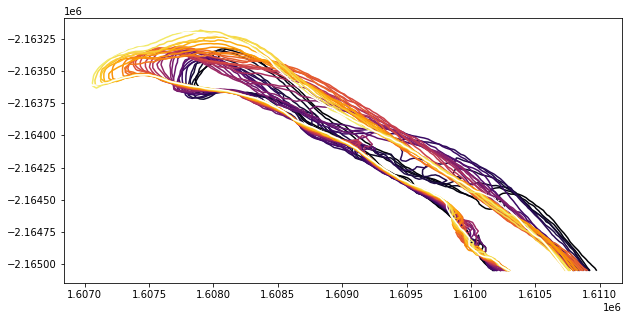

In [2]:
# # Get bounding box of data
# site = 'barbeach'
# offset=0
# ymax, xmin = -32.94020, 151.75523
# ymin, xmax = -32.95006, 151.77255

# # Get bounding box of data
# site = 'capeperon'
# offset=545
# ymax, xmin = -32.2728511,115.6928997
# ymin, xmax = -32.277,115.698

# # Get bounding box of data
# site = 'twilightcove'
# offset=0
# ymax, xmin = -32.261237, 126.024825
# ymin, xmax = -32.288332, 126.085

# Get bounding box of data
site = 'nobbys'
offset = 0 
y, x = -32.9219, 151.79677
width = 850
ratio = 0.5
legend_width = 200

# Get bounding box of data
site = 'twilightcove'
offset = 0
y, x = -32.276, 126.057
width = 3000
ratio = 0.5
legend_width = 1000

# Get bounding box of data
site = 'barbeach'
offset = 0
y, x = -32.945, 151.764
width = 900
ratio = 0.5
legend_width = 100

# Get bounding box of data
site = 'byronbay'
offset = 290
y, x = -28.6385, 153.624053
width = 1500
ratio = 0.5
legend_width = 200

# Get bounding box of data
site = 'tweedheads'
offset = 290
y, x = -28.166068, 153.535
width = 2500
ratio = 0.5
legend_width = 200

# Get bounding box of data
site = 'bowlinggreen'
offset = 290
y, x = -19.3045, 147.393
width = 2400
ratio = 0.5
legend_width = 500


# Load data
deacl_gdf, bounds = load_animation_data(y, x, width, ratio)

In [ ]:
plot_alltime(site, deacl_gdf, bounds, legend_width, offset)


In [ ]:
plot_years(site, deacl_gdf, bounds, legend_width, offset)


In [15]:
!ffmpeg -y -r 2 -start_number 1988 -i Frames/{site}_%4d.png -c:v libx264 -vf "fps=2,format=yuv420p,pad=ceil(iw/2)*2:ceil(ih/2)*2" temp.mp4
!ffmpeg -y -i temp.mp4 -filter_complex "[0]trim=0:7[hold],[0][hold]concat[extended],[extended][0]overlay" -pix_fmt yuv420p -c:a copy deacoastlines_{site}_animation.mp4
# !ffmpeg -y -i deacoastlines_{site}_animation.mp4 -vf "minterpolate=fps=30:mi_mode=blend" -threads 7 test.mp4
# !ffmpeg -y -t 2 -i deacoastlines_{site}_animation.mp4 -vf "minterpolate='mi_mode=mci:mc_mode=aobmc:vsbmc=1:fps=120:me=fss'" test.mp4 -threads 7




ffmpeg version 3.3.4-static http://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 6.4.0 (Debian 6.4.0-4) 20170820
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc-6 --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gray --enable-libfribidi --enable-libass --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-librtmp --enable-libsoxr --enable-libspeex --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libzimg
  libavutil      55. 58.100 / 55. 58.100
  libavcodec     57. 89.100 / 57. 89.100
  libavformat    57. 71.100 / 57. 71.100
  libavdevice    57.  6.100 / 57.  6.100
  libavfilter     6. 82.100 /  6.